<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP4</h2></center>

# Importation des librairies

In [73]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

# Importation du dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [6]:
!unzip  /content/drive/MyDrive/iaa/archive.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align

In [14]:
BASIC_PATH = "/content/"
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
NM_IMGS = 1000

pd.set_option('display.max_colwidth', None)

df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'], nrows=NM_IMGS)
df.head()

,image_id,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [15]:
df.loc[df['Male'] == -1,'Male'] = "female"
df.loc[df['Male'] == 1,'Male'] = "male"

# alterando nome das colunas
df.columns = ["image_id", "gender"]

# listando os 10 primeiros
df.head(10)

,image_id,gender
0,000001.jpg,female
1,000002.jpg,female
2,000003.jpg,male
3,000004.jpg,female
4,000005.jpg,female
5,000006.jpg,female
6,000007.jpg,male
7,000008.jpg,male
8,000009.jpg,female
9,000010.jpg,female


# Analyse et visualisation du dataset

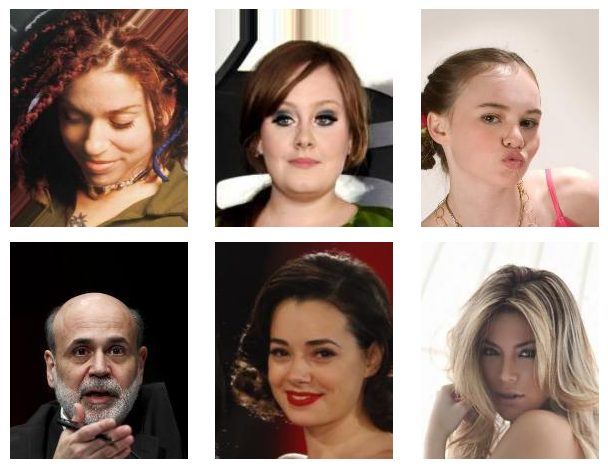

In [16]:
for index in range(0, 6):
    plt.subplot(2, 3, index+1)

    # ler imagen
    img = cv2.imread(IMG_PATH + '/' + df.sample(6)["image_id"].values[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # adicionar imagen no matplot
    plt.imshow(img)
    plt.axis('off')

# exibir matplot
plt.tight_layout()
plt.show()

In [17]:
category_count = df["gender"].value_counts()
category_count

female    568
male      432
Name: gender, dtype: int64

In [18]:
female_indices = df[df["gender"] == "female"].index
df = df.drop(female_indices[:category_count[0] - category_count[1]])

<Axes: >

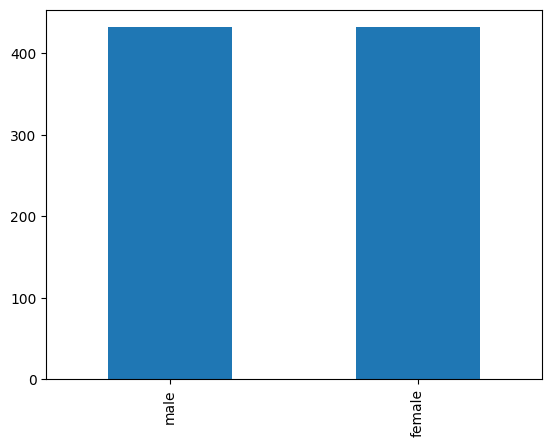

In [19]:
df["gender"].value_counts().plot.bar()

# Séparation and train, test et val set

In [53]:
X = df["image_id"]

y = df["gender"]

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size = 0.33)
X_test, X_val, y_test, y_val  = train_test_split(X_val, y_val, test_size = 0.50)

In [71]:
train_images, test_images, val_images = [], [], []

for xt in X_train:
  train_images += [cv2.imread(IMG_PATH + '/' + xt)]

for xv in X_val:
  val_images += [cv2.imread(IMG_PATH + '/' + xv)]

for xt in X_test:
  test_images += [cv2.imread(IMG_PATH + '/' + xt)]

train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Prétraitement des données

In [72]:
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
val_images /= 255
test_images /= 255

train_images.shape, y_train.shape, val_images.shape, y_val.shape, test_images.shape, y_test.shape

((578, 218, 178, 3),
 (578,),
 (143, 218, 178, 3),
 (143,),
 (143, 218, 178, 3),
 (143,))

# Classification avec InceptionV3

## Importation du modèle

In [ ]:
def inception_model(nbn, dp):
  model = InceptionV3(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

  for layer in model.layers[:]:
    layer.trainable = False

  output = model.output
  output = Flatten()(output)
  output = Dense(units=int(nbn), activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=int(nbn)//8, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=1, activation='softmax')(output)
  model = Model(model.input, output)

  model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])
  
  return model

## Affinage avec GWO

In [ ]:
nombre_de_neurones = [512, 1024, 2048]
dropout = [0.2, 0.3, 0.4]
batch_size = [32, 64, 128, 256]

In [1]:
def objective_function(x):
    model = inception_model(x[0], x[1])

    history = model.fit(train_images , y_train,
              batch_size=x[2], epochs=100,
              verbose=0,
              validation_data=(val_images, y_val))

    return history.history['val_accuracy'][-1]

def initialize_population(population_size):
    return [random.choice(nombre_de_neurones), random.choice(dropout), random.choice(batch_size) for _ in range(population_size)]

def gwo_algorithm(obj_function, population_size, dimension, iterations):
    # Initialiser la population de loups
    wolves_positions = initialize_population(population_size)
    
    for iteration in range(iterations):
        # Évaluation des solutions
        fitness_values = np.array([obj_function(wolf) for wolf in wolves_positions])

        # Identifier les loups alpha, bêta et delta
        alpha_index = np.argmin(fitness_values)
        beta_index = np.argsort(fitness_values)[1]
        delta_index = np.argsort(fitness_values)[2]

        alpha_position = wolves_positions[alpha_index]
        beta_position = wolves_positions[beta_index]
        delta_position = wolves_positions[delta_index]

        # Mise à jour des positions des loups
        a = 2 * (1 - (iteration / iterations))  # Coefficient d'ajustement
        for i in range(population_size):
            r1 = np.random.rand(dimension)
            r2 = np.random.rand(dimension)

            A1 = 2 * r1 * a - a
            C1 = 2 * r2

            distance_alpha = np.linalg.norm(wolves_positions[i] - alpha_position)
            distance_beta = np.linalg.norm(wolves_positions[i] - beta_position)
            distance_delta = np.linalg.norm(wolves_positions[i] - delta_position)

            updated_position = wolves_positions[i] - A1 * distance_alpha - A1 * distance_beta - C1 * distance_delta
            wolves_positions[i] = np.clip(updated_position, 0, 1)  # Assurer que les positions restent dans l'espace de recherche

    # Retourner la meilleure solution trouvée
    best_index = np.argmin(fitness_values)
    best_solution = wolves_positions[best_index]
    best_fitness = fitness_values[best_index]

    return best_solution, best_fitness

# Paramètres de l'algorithme
population_size = 10
dimension = 3
iterations = 100

# Exécuter l'algorithme GWO
best_solution, best_fitness = gwo_algorithm(objective_function, population_size, dimension, iterations)

print("Meilleure solution trouvée:", best_solution)

Meilleure solution trouvée: [1024, 0.3, 256]


## Entrainement du modèle

In [105]:
model = InceptionV3(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

for layer in model.layers[:]:
  layer.trainable = False

output = model.output
output = Flatten()(output)
output = Dense(units=1024, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.3)(output)
output = Dense(units=128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.3)(output)
output = Dense(units=1, activation='softmax')(output)
model = Model(model.input, output)


model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

history = model.fit(train_images , y_train,
              batch_size=256, epochs=100,
              verbose=2,
              validation_data=(val_images, y_val))

Epoch: 1/100
18/18 - 46s - loss: 2.1470 - accuracy: 0.0786 - val_loss: 2.7840 - val_accuracy: 0.0697 - 46s/epoch - 15s/step
Epoch: 2/100
18/18 - 58s - loss: 2.1466 - accuracy: 0.0787 - val_loss: 2.7833 - val_accuracy: 0.0698 - 58s/epoch - 15s/step
Epoch: 3/100
18/18 - 42s - loss: 2.1454 - accuracy: 0.0792 - val_loss: 2.7829 - val_accuracy: 0.0701 - 42s/epoch - 15s/step
Epoch: 4/100
18/18 - 46s - loss: 2.1440 - accuracy: 0.0796 - val_loss: 2.7825 - val_accuracy: 0.0708 - 46s/epoch - 15s/step
Epoch: 5/100
18/18 - 56s - loss: 2.1421 - accuracy: 0.0803 - val_loss: 2.7789 - val_accuracy: 0.0711 - 56s/epoch - 15s/step
Epoch: 6/100
18/18 - 46s - loss: 2.1413 - accuracy: 0.0805 - val_loss: 2.7780 - val_accuracy: 0.0715 - 46s/epoch - 15s/step
Epoch: 7/100
18/18 - 42s - loss: 2.1396 - accuracy: 0.0807 - val_loss: 2.7778 - val_accuracy: 0.0717 - 42s/epoch - 15s/step
Epoch: 8/100
18/18 - 45s - loss: 2.1392 - accuracy: 0.0808 - val_loss: 2.7734 - val_accuracy: 0.0730 - 45s/epoch - 15s/step
Epoch: 9

# Visualisation des résultats

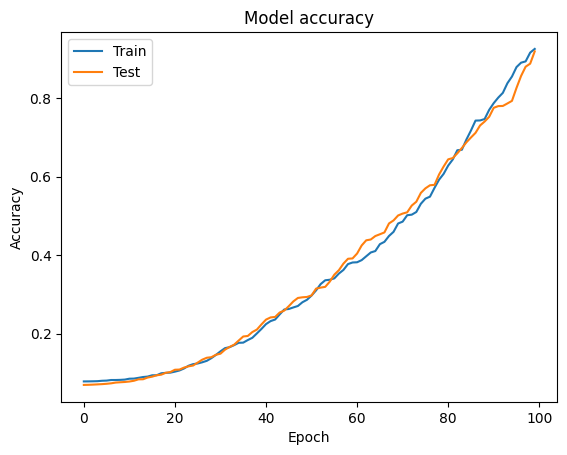

In [75]:
# plot accuracy and val_accuracy
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

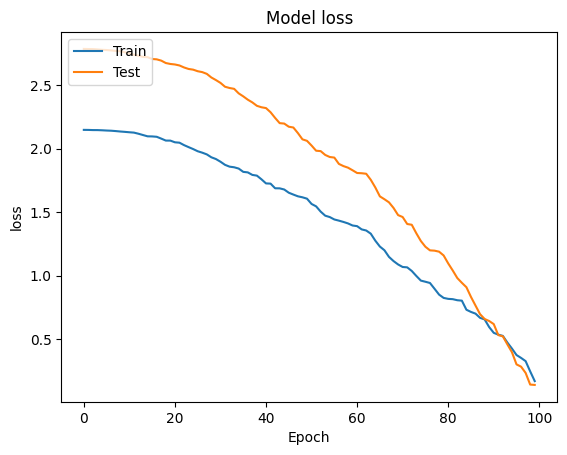

In [76]:
# plot loss and val_loss
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [86]:
test = np.array(y_test.value_counts().tolist())

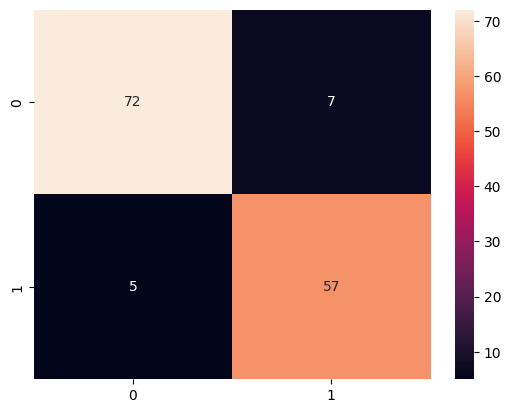

In [90]:
y_predicted = model.predict(y_test)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted)

plt.figure()
sns.heatmap(cm, annot=True)
plt.show()

# Classification avec ResNet50

## Importation du modèle

In [ ]:
def resnet_model(nbn, dp):
  model = ResNet50(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

  for layer in model.layers[:]:
    layer.trainable = False

  output = model.output
  output = Flatten()(output)
  output = Dense(units=int(nbn), activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=int(nbn)//8, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=1, activation='softmax')(output)
  model = Model(model.input, output)

  model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])
  
  return model

## Affinage avec GWO

In [2]:
def objective_function(x):
    model = resnet_model(x[0], x[1])

    history = model.fit(train_images , y_train,
              batch_size=x[2], epochs=100,
              verbose=0,
              validation_data=(val_images, y_val))

    return history.history['val_accuracy'][-1]

# Paramètres de l'algorithme
population_size = 10
dimension = 3
iterations = 100

# Exécuter l'algorithme GWO
best_solution, best_fitness = gwo_algorithm(objective_function, population_size, dimension, iterations)

print("Meilleure solution trouvée:", best_solution)

Meilleure solution trouvée: [1024, 0.3, 32]


## Entrainement du modèle

In [103]:
model = ResNet50(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

for layer in model.layers[:]:
  layer.trainable = False

output = model.output
output = Flatten()(output)
output = Dense(units=1024, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.33)(output)
output = Dense(units=128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.33)(output)
output = Dense(units=1, activation='softmax')(output)
model = Model(model.input, output)


model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

history = model.fit(train_images , y_train,
              batch_size=32, epochs=100,
              verbose=2,
              validation_data=(val_images, y_val))

Epoch: 1/100
18/18 - 58s - loss: 3.0270 - accuracy: 0.0806 - val_loss: 3.2680 - val_accuracy: 0.0714 - 58s/epoch - 15s/step
Epoch: 2/100
18/18 - 50s - loss: 3.0259 - accuracy: 0.0809 - val_loss: 3.2669 - val_accuracy: 0.0715 - 50s/epoch - 15s/step
Epoch: 3/100
18/18 - 44s - loss: 3.0258 - accuracy: 0.0814 - val_loss: 3.2652 - val_accuracy: 0.0721 - 44s/epoch - 15s/step
Epoch: 4/100
18/18 - 57s - loss: 3.0240 - accuracy: 0.0815 - val_loss: 3.2645 - val_accuracy: 0.0725 - 57s/epoch - 15s/step
Epoch: 5/100
18/18 - 50s - loss: 3.0208 - accuracy: 0.0826 - val_loss: 3.2614 - val_accuracy: 0.0735 - 50s/epoch - 15s/step
Epoch: 6/100
18/18 - 59s - loss: 3.0173 - accuracy: 0.0842 - val_loss: 3.2593 - val_accuracy: 0.0740 - 59s/epoch - 15s/step
Epoch: 7/100
18/18 - 40s - loss: 3.0119 - accuracy: 0.0847 - val_loss: 3.2544 - val_accuracy: 0.0742 - 40s/epoch - 15s/step
Epoch: 8/100
18/18 - 48s - loss: 3.0071 - accuracy: 0.0852 - val_loss: 3.2543 - val_accuracy: 0.0759 - 48s/epoch - 15s/step
Epoch: 9

## Visualisation des résultats

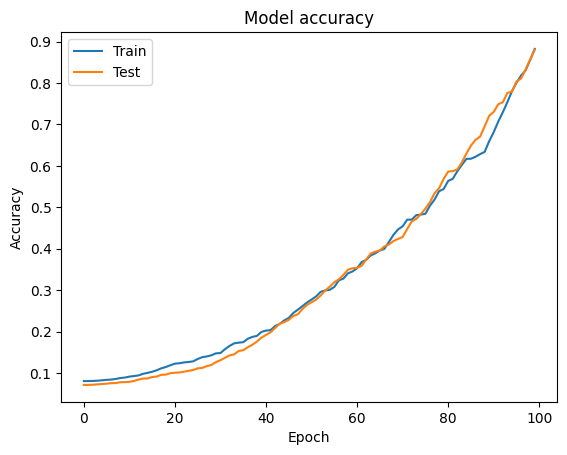

In [92]:
# plot accuracy and val_accuracy
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

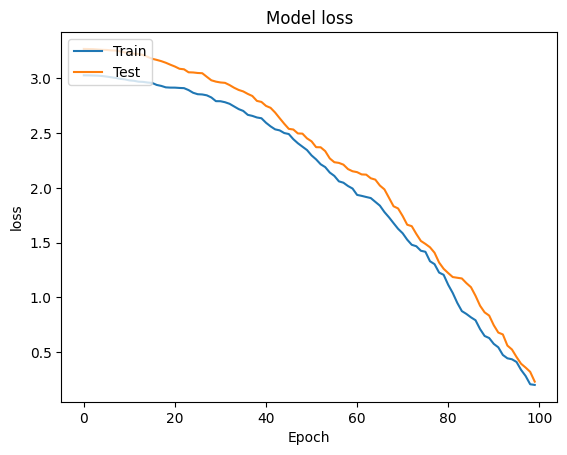

In [93]:
# plot loss and val_loss
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

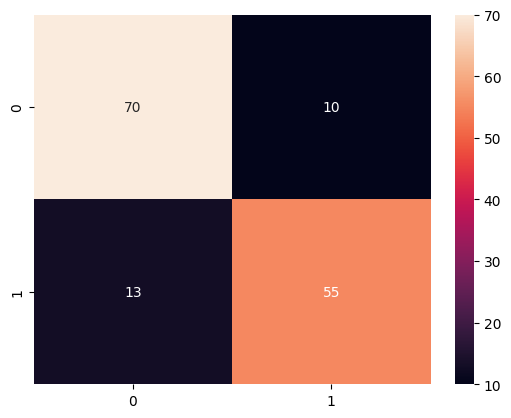

In [95]:
y_predicted = model.predict(y_test)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted)

plt.figure()
sns.heatmap(cm, annot=True)
plt.show()

# Classification avec VGG19

## Création de l'architecture

In [ ]:
def vgg19_model(nbn, dp):
  model = VGG19(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

  for layer in model.layers[:]:
    layer.trainable = False

  output = model.output
  output = Flatten()(output)
  output = Dense(units=int(nbn), activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=int(nbn)//8, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
  output = Dropout(dp)(output)
  output = Dense(units=1, activation='softmax')(output)
  model = Model(model.input, output)

  model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])
  
  return model

## Affinage avce GWO

In [3]:
def objective_function(x):
    model = vgg19_model(x[0], x[1])

    history = model.fit(train_images , y_train,
              batch_size=x[2], epochs=100,
              verbose=0,
              validation_data=(val_images, y_val))

    return history.history['val_accuracy'][-1]

# Paramètres de l'algorithme
population_size = 10
dimension = 3
iterations = 100

# Exécuter l'algorithme GWO
best_solution, best_fitness = gwo_algorithm(objective_function, population_size, dimension, iterations)

print("Meilleure solution trouvée:", best_solution)

Meilleure solution trouvée: [1024, 0.3, 256]


## Entrainement du modèle

In [104]:
model = VGG19(include_top=False, input_shape=(218, 178, 3), weights='imagenet')

for layer in model.layers[:]:
  layer.trainable = False

output = model.output
output = Flatten()(output)
output = Dense(units=1024, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.33)(output)
output = Dense(units=128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(output)
output = Dropout(0.33)(output)
output = Dense(units=1, activation='softmax')(output)
model = Model(model.input, output)


model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

history = model.fit(train_images , y_train,
              batch_size=256, epochs=100,
              verbose=2,
              validation_data=(val_images, y_val))

Epoch: 1/100
18/18 - 59s - loss: 2.9450 - accuracy: 0.0761 - val_loss: 3.0460 - val_accuracy: 0.0694 - 59s/epoch - 15s/step
Epoch: 2/100
18/18 - 54s - loss: 2.9443 - accuracy: 0.0763 - val_loss: 3.0453 - val_accuracy: 0.0695 - 54s/epoch - 15s/step
Epoch: 3/100
18/18 - 45s - loss: 2.9427 - accuracy: 0.0766 - val_loss: 3.0434 - val_accuracy: 0.0695 - 45s/epoch - 15s/step
Epoch: 4/100
18/18 - 42s - loss: 2.9403 - accuracy: 0.0770 - val_loss: 3.0412 - val_accuracy: 0.0696 - 42s/epoch - 15s/step
Epoch: 5/100
18/18 - 41s - loss: 2.9366 - accuracy: 0.0778 - val_loss: 3.0406 - val_accuracy: 0.0701 - 41s/epoch - 15s/step
Epoch: 6/100
18/18 - 58s - loss: 2.9344 - accuracy: 0.0793 - val_loss: 3.0387 - val_accuracy: 0.0715 - 58s/epoch - 15s/step
Epoch: 7/100
18/18 - 53s - loss: 2.9327 - accuracy: 0.0798 - val_loss: 3.0346 - val_accuracy: 0.0737 - 53s/epoch - 15s/step
Epoch: 8/100
18/18 - 44s - loss: 2.9316 - accuracy: 0.0808 - val_loss: 3.0281 - val_accuracy: 0.0751 - 44s/epoch - 15s/step
Epoch: 9

## Visualisation des résultats

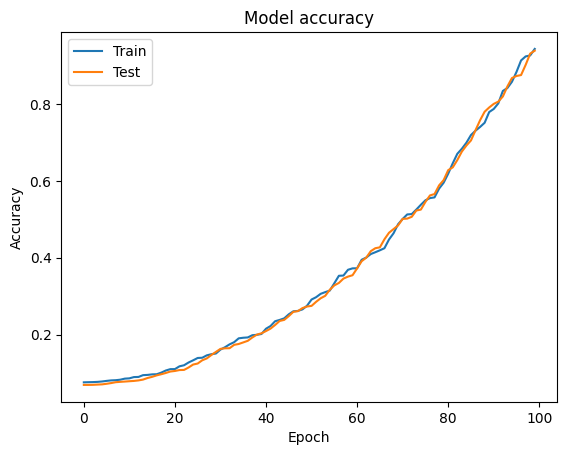

In [97]:
# plot accuracy and val_accuracy
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

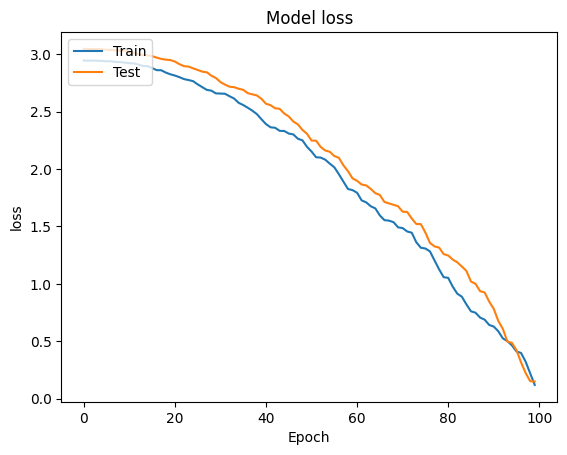

In [98]:
# plot loss and val_loss
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

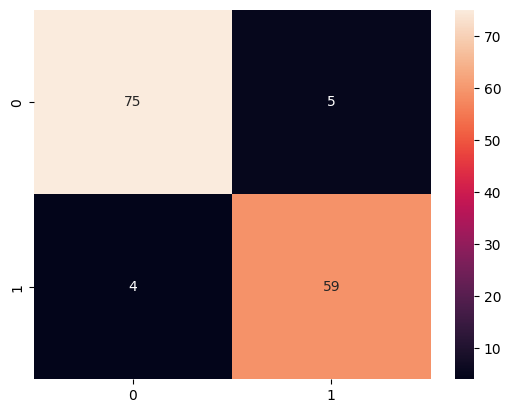

In [100]:
y_predicted = model.predict(y_test)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted)

plt.figure()
sns.heatmap(cm, annot=True)
plt.show()